In [1]:
from absl import logging
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
from six import BytesIO
import tensorflow as tf
import tensorflow_hub as hub
from six.moves.urllib.request import urlopen

In [23]:
#title Select image from image Set to perform image matching
img_select = "White House" #@param ["Liberty Tower", "White House", "Piza Tower", "Eiffel tower"]
if img_select == "Liberty Tower":
  IMAGE_1_URL = 'https://media.timeout.com/images/101382127/image.jpg'
  IMAGE_2_URL = 'https://cdn.britannica.com/71/99571-050-DFF0A6E5/Statue-of-Liberty-Island-New-York.jpg'
elif img_select == "White House":
  IMAGE_1_URL = 'https://www.whitehouse.gov/wp-content/uploads/2022/05/WHAJAC.jpg'
  IMAGE_2_URL = 'https://www.thoughtco.com/thmb/D_Ud8O1MHaMpb_NX6nZ3MPOV2F8=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/GettyImages-117950117-969baa3b88ca430d8e51d6132371fa8e.jpg'
elif img_select == "Piza Tower":
  IMAGE_1_URL = 'https://media.istockphoto.com/id/675711554/photo/piazza-del-duomo-with-leaning-tower-in-pisa.jpg?s=612x612&w=0&k=20&c=hxyEDnZlNM2ih7FS4YeU50Gp4Y_i-6tUxGp2RuYMt6o='
  IMAGE_2_URL = 'https://www.kevinandamanda.com/wp-content/uploads/2018/02/leaning-tower-pisa-lucca-italy-01.jpg'
else:
  IMAGE_1_URL = 'https://upload.wikimedia.org/wikipedia/commons/d/d8/Eiffel_Tower%2C_November_15%2C_2011.jpg'
  IMAGE_2_URL = 'https://upload.wikimedia.org/wikipedia/commons/a/a8/Eiffel_Tower_from_immediately_beside_it%2C_Paris_May_2008.jpg'


C:\Users\renad\AppData\Local\Temp\ipykernel_21092\1792757552.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = ImageOps.fit(img, (new_width, new_height), Image.ANTIALIAS)


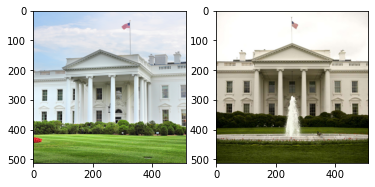

In [24]:
def download_and_resize(name, url, new_width=512, new_height=512):
  path = tf.keras.utils.get_file(url.split('/')[-1], url)
  img = Image.open(path)
  img = ImageOps.fit(img, (new_width, new_height), Image.ANTIALIAS)
  return img

img1 = download_and_resize('first_img.jpg', IMAGE_1_URL)
img2 = download_and_resize('second_img.jpg', IMAGE_2_URL)

plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)

In [25]:
delf = hub.load('https://tfhub.dev/google/delf/1').signatures['default']

def run_delf(image):
  np_image = np.array(image)
  float_image = tf.image.convert_image_dtype(np_image, tf.float32)

  return delf(
      image=float_image,
      score_threshold=tf.constant(100.0),
      image_scales=tf.constant([0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0]),
      max_feature_num=tf.constant(1000))
result1 = run_delf(img1)
result2 = run_delf(img2)

In [26]:
def match_images(img1, img2, result1, result2):
  distance_threshold = 0.8
  # Read features.
  num_features_1 = result1['locations'].shape[0]
  print("Loaded image 1's %d features" % num_features_1)
  num_features_2 = result2['locations'].shape[0]
  print("Loaded image 2's %d features" % num_features_2)

  # Find nearest-neighbor matches using a KD tree.
  d1_tree = cKDTree(result1['descriptors'])
  _, indices = d1_tree.query(
      result2['descriptors'],
      distance_upper_bound=distance_threshold)
  
  # Select feature locations for putative matches.
  locations_2_to_use = np.array([
      result2['locations'][i,]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])
  locations_1_to_use = np.array([
      result1['locations'][indices[i],]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])

  # Perform geometric verification using RANSAC.
  _, inliers = ransac(
      (locations_1_to_use, locations_2_to_use),
      AffineTransform,
      min_samples=3,
      residual_threshold=20,
      max_trials=1000)

  print('Found %d inliers' % sum(inliers))

  # Visualize correspondences.
  _, ax = plt.subplots()
  inlier_idxs = np.nonzero(inliers)[0]
  plot_matches(
      ax,
      img1,
      img2,
      locations_1_to_use,
      locations_2_to_use,
      np.column_stack((inlier_idxs, inlier_idxs)),
      matches_color='b')
  ax.axis('off')
  ax.set_title('DELF correspondences')

Loaded image 1's 495 features
Loaded image 2's 494 features
Found 80 inliers


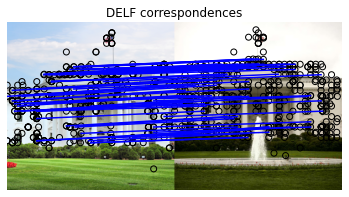

In [27]:
match_images(img1, img2, result1, result2)